In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        "/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",
        # "/Users/louis/Data/JWST/amigo_data/calibrators/train_set/",
        # "/Users/louis/Data/JWST/amigo_data/ERS1386/calslope/",
        # "/Users/louis/Data/JWST/amigo_data/COMM1903/calslope/",
    ],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    EXPOSURE=[str(i + 1) for i in range(5)],  # Which sub-pixel position
    **kwargs,
)

_files = [] + file_fn(FILTER="F380M") + file_fn(FILTER="F430M") + file_fn(FILTER="F480M")
# _files = ([] +file_fn(FILTER="F480M"))

# Remove duplicates
files, fnames = [], []
for file in _files:
    head = file["PRIMARY"].header
    if head["filename"] not in fnames:
        files.append(file)
    fnames.append(head["filename"])


# fnames = [f["PRIMARY"].header["filename"] for f in files]

# files = files[:1]

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS", "EXPOSURE"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



15
  TARGPROP: HD-41094
  FILTER: F430M, F480M, F380M
  NINTS: 760, 905, 1060
  NGROUPS: 11, 20, 30
  OBSERVTN: 001
  NCHUNKS: 1
  EXPOSURE: 2, 4, 3, 5, 1


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

In [4]:
# import jax.numpy as np

# for file in files:
#     print(file[0].header["FILENAME"])
#     nints = file[0].header["NINTS"]
#     ngroups = file[0].header["NGROUPS"]
#     print(nints)
#     print(ngroups)

#     # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
#     data = np.sum(np.asarray(file["SCI"].data, float), 0)
#     var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)

#     nphot_per_im = np.nansum(data)
#     nphot_tot = nints * nphot_per_im
#     print(nphot_tot * 1e-6)

#     plt.figure(figsize=(20, 4))
#     plt.subplot(1, 4, 1)
#     plt.title("Data")
#     plt.imshow(data)
#     plt.colorbar()

#     plt.subplot(1, 4, 2)
#     plt.title("Log10 Data")
#     plt.imshow(np.log10(data))
#     plt.colorbar()

#     plt.subplot(1, 4, 3)
#     plt.title("Variance")
#     # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
#     plt.imshow(var)
#     plt.colorbar()

#     plt.subplot(1, 4, 4)
#     plt.title("Log10 Variance")
#     # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
#     plt.imshow(np.log10(var))
#     plt.colorbar()
#     plt.show()

#     # data = np.nansum(np.abs(np.asarray(file["SCI"].data, float)), 0)
#     psf_est = np.asarray(file["SCI"].data, float)[0]
#     # var = np.sum(np.asarray(file["SCI_VAR"].data, float), 0)
#     zpoint = np.asarray(file["ZPOINT"].data, float)
#     zpoint_var = np.asarray(file["ZPOINT_VAR"].data, float)

#     plt.figure(figsize=(20, 4))
#     plt.subplot(1, 4, 1)
#     plt.title("Bias Estimate")
#     plt.imshow(zpoint - psf_est)
#     plt.colorbar()

#     plt.subplot(1, 4, 2)
#     plt.title("Bias Est Histogram")
#     # plt.imshow(np.log10(zpoint - psf_est))
#     plt.hist((zpoint - psf_est).flatten(), bins=50)

#     plt.subplot(1, 4, 3)
#     plt.title("Zero-Point Variance")
#     # plt.imshow(file["SCI_VAR"].data.sum(0) * nints)
#     plt.imshow(zpoint_var)
#     plt.colorbar()

#     plt.subplot(1, 4, 4)
#     plt.title("Log10 Zero-Point Variance")
#     # plt.imshow(np.log10(file["SCI_VAR"].data.sum(0) * nints))
#     plt.imshow(np.log10(zpoint_var))
#     plt.colorbar()
#     plt.show()

In [5]:
import jax.numpy as np
from amigo.core_models import AmigoModel
from amigo.optical_models import AMIOptics
from amigo.detector_models import LinearDetectorModel
from amigo.read_models import ReadModel
from amigo.ramp_models import SimpleRamp, PolyNonLin
from amigo.files import get_exposures, initialise_params
from amigo.model_fits import PointFit

oversample = 4
optics = AMIOptics(radial_orders=4, oversize=1.1, oversample=oversample)
detector = LinearDetectorModel(oversample=oversample)
ramp_model = PolyNonLin(oversample=oversample)
read_model = ReadModel()

# Prep the model
fit = PointFit()
exposures = get_exposures(files, fit)
params = initialise_params(exposures, optics, fit_one_on_fs=False)

# Add the binary parameters
model = AmigoModel(
    files, params, optics=optics, detector=detector, ramp=ramp_model, read=read_model
)

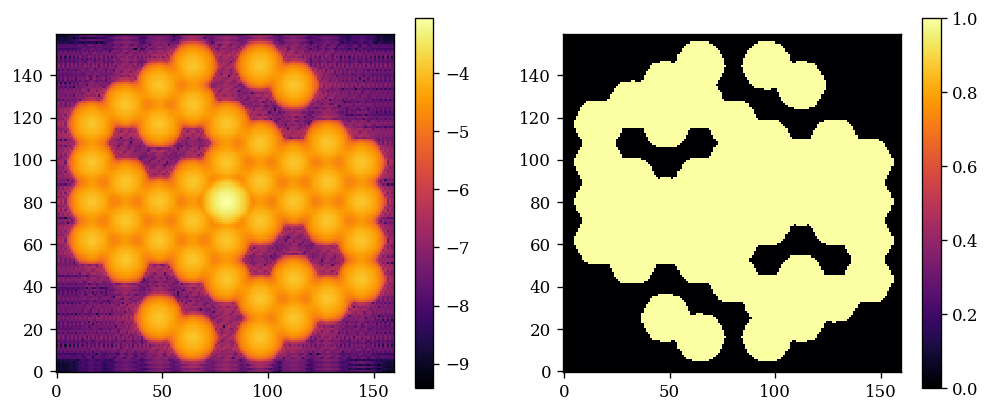

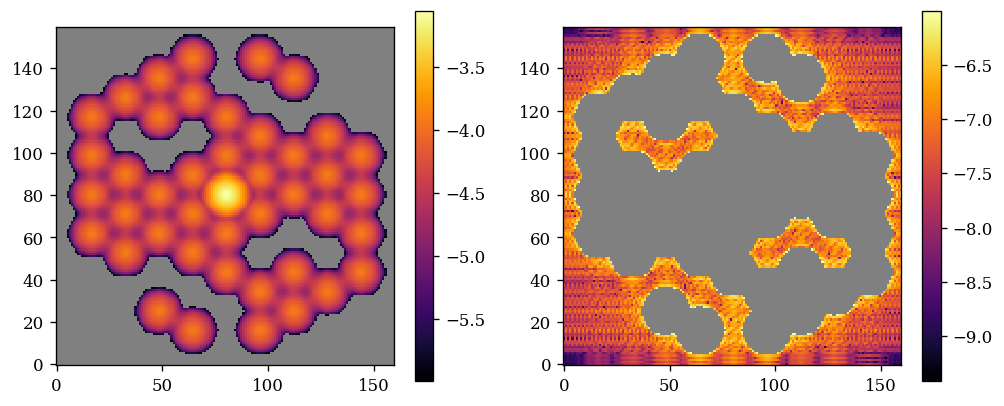

In [6]:
from jax import vmap
import interpax as ipx
import dLux.utils as dlu
from amigo.interferometry import to_uv, from_uv

psfs = fit.model_wfs(model, exposures[0]).psf

padded = vmap(lambda x: dlu.resize(x, 2*psfs.shape[-1]))(psfs)
full_splodges = vmap(to_uv)(padded)

c = full_splodges.shape[-1] // 2
s = 80
splodges = np.abs(full_splodges[:, c - s : c + s, c - s : c + s])


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# plt.imshow(np.abs(splodges[0]) ** 0.25)
plt.imshow(np.log10(np.abs(splodges[0])))
# plt.imshow(np.abs(splodges[0]))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.abs(splodges[0]) > 1e-6)
plt.colorbar()
plt.show()

mask = np.abs(splodges[0]) > 1e-6
inner = np.where(mask, splodges[0], np.nan)
outer = np.where(~mask, splodges[0], np.nan)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(inner), cmap=inferno)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.log10(outer), cmap=inferno)
plt.colorbar()
plt.show()

In [7]:
# def gaussian(sigma, coords):
def gaussian(sigma, nx, ny):
    # def gaussian(sigma, npix):

    """
    Create a 2D Gaussian array.

    Parameters:
    sigma (float): Standard deviation of the Gaussian.
    npix (int): Number of pixels along each dimension.

    Returns:
    np.ndarray: 2D Gaussian array.
    """
    # coords = dlu.pixel_coords(npix, 2)
    xs, ys = np.linspace(-1, 1, nx), np.linspace(-1, 1, ny)
    y, x = np.meshgrid(xs, ys)

    # Calculate the 2D Gaussian
    gaussian = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return gaussian

In [8]:
import jax.random as jr
from amigo.interferometry import get_baselines_and_inds, osamp_freqs


# Create the splodges
uv_pad = 2
exp = exposures[0]
psfs = fit.model_wfs(model, exp).psf
padded = vmap(lambda x: dlu.resize(x, uv_pad * psfs.shape[-1]))(psfs)
npix_in = padded.shape[-1]

# Crop the splodges
npix_out = 146
full_splodges = vmap(to_uv)(padded).sum(0)
splodges = np.abs(dlu.resize(full_splodges, npix_out))

# Mask outside the OTF region - Shouldn't need to be done in practice
mask = np.abs(splodges) > 1e-3
# inner = np.where(mask, splodges, np.nan)
# outer = np.where(~mask, splodges, np.nan)

# Make interpolator of the visibilities on the OTF coordinates
cen_holes = optics.holes - optics.holes.mean(0)[None, :]
# cen_holes = optics.holes
hbls, inds = get_baselines_and_inds(cen_holes)
bls = np.concatenate([np.zeros((1, 2)), hbls, -hbls]).T
# nx, ny = 17, 15
nx, ny = 9, 15
xs = bls.max() * np.linspace(-1, 1, nx)
# r = ny * (1 / (ny - 1))
r = 1
ys = bls.max() * np.linspace(-r, r, ny)
# fs = gaussian(0.5, nx, ny).T
# fs /= fs.max()
# interp = ipx.Interpolator2D(xs, ys, fs, method="cubic2", extrap=True)

# Define visibility coords
wavels, weights = model.filters[exp.filter]
lam = ((wavels * weights).sum() / weights.sum()).mean()
dx = dlu.arcsec2rad(optics.psf_pixel_scale) / (optics.oversample * lam)

crop_to = lambda arr, npix: arr[(len(arr) - npix) // 2 : (len(arr) + npix) // 2]
u_coords = crop_to(osamp_freqs(full_splodges.shape[-1], dx), npix_out)

# # Get and apply visibility map
# grid_interp = lambda xs, ys: interp(xs.flatten(), ys.flatten()).reshape(xs.shape)
# full_vis = grid_interp(*np.meshgrid(u_coords, u_coords))
# # vis_map = np.where(mask, full_vis, np.nan)
# applied_splodges = full_vis * splodges

#
print(f"{nx * ny} control points\t{4 * nx * ny} parameters")

135 control points	540 parameters


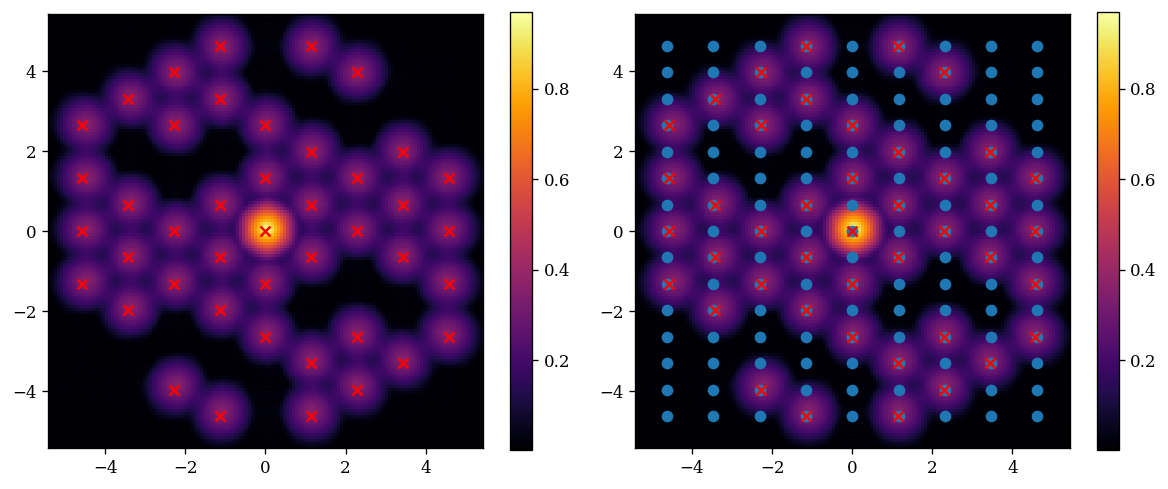

In [9]:
plt.figure(figsize=(10, 8))
ext = u_coords.max()

plt.subplot(2, 2, 1)
# plt.scatter(*np.meshgrid(xs, ys))
plt.scatter(bls[0], bls[1], alpha=1, marker="x", c="r")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.scatter(*np.meshgrid(xs, ys))
plt.scatter(bls[0], bls[1], alpha=1, marker="x", c="r")
plt.imshow(splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
plt.colorbar()

# plt.subplot(2, 2, 3)
# plt.imshow(applied_splodges**0.5, extent=(-ext, ext, -ext, ext), cmap=inferno)
# plt.colorbar()

# plt.subplot(2, 2, 4)
# plt.imshow(full_vis**2, extent=(-ext, ext, -ext, ext), cmap=inferno)
# plt.colorbar()

plt.tight_layout()
plt.show()

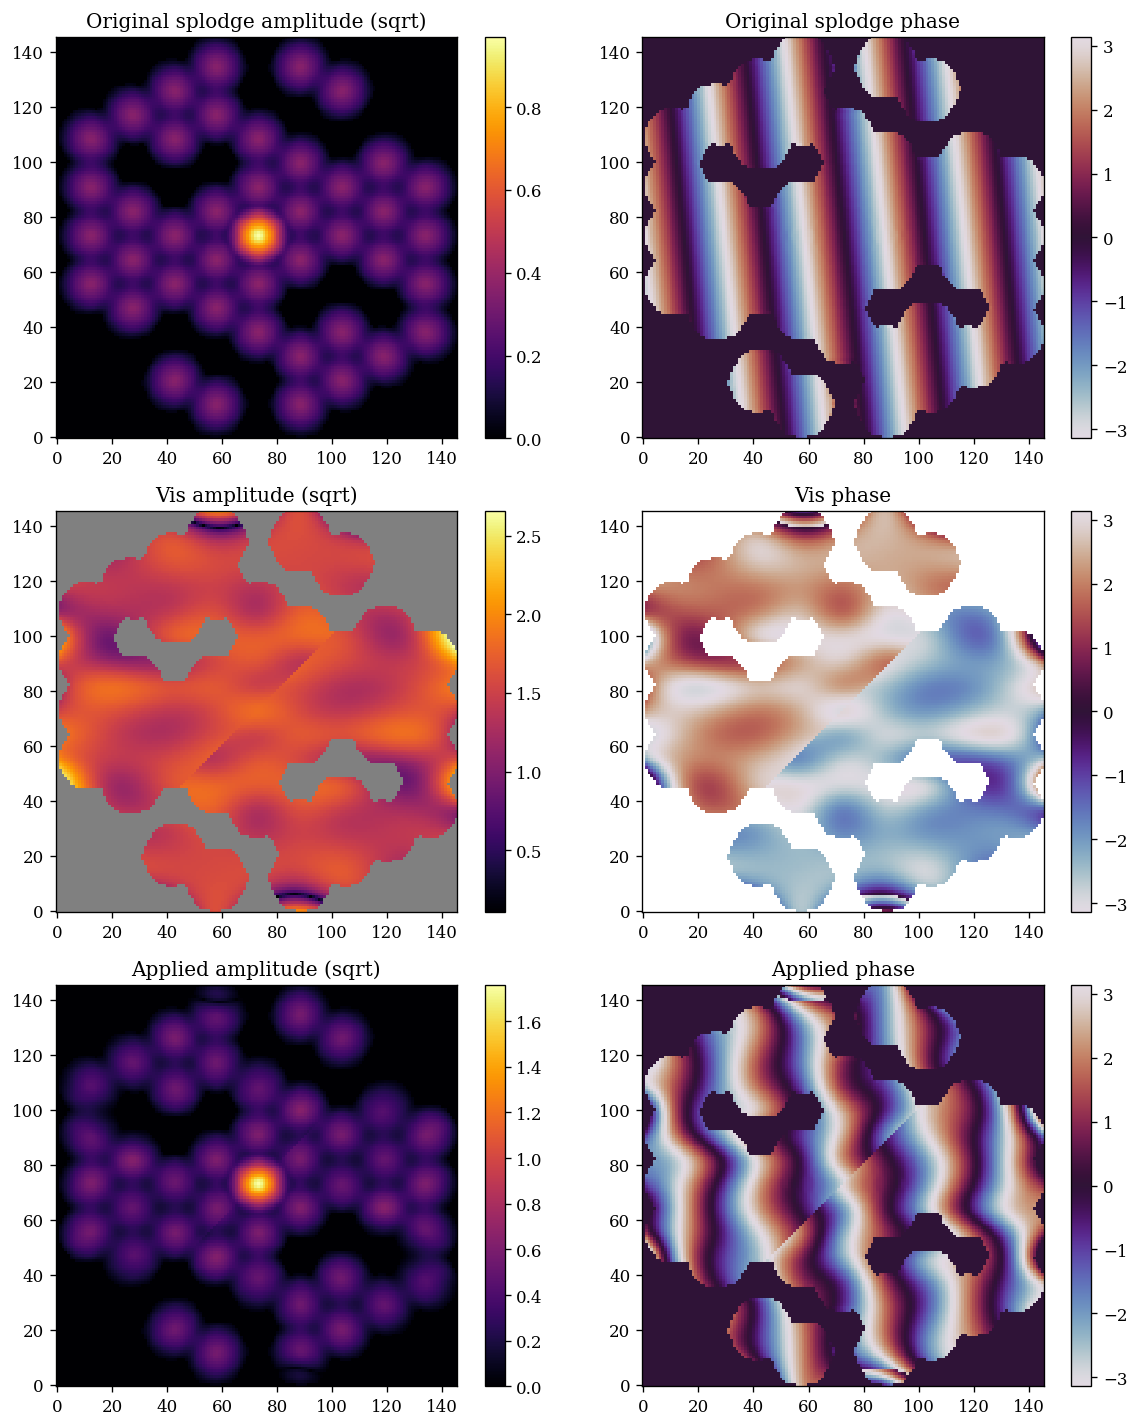

In [10]:
# complex conjugate always has some amplitude but different _phase_
kern = gaussian(0.2, 7, 7)

#
amp_points = 1 + 0.5 * jr.normal(jr.PRNGKey(0), (nx + 4, ny + 4))
convd_amp = jax.scipy.signal.convolve(amp_points, kern, mode="same")[2:-2, 2:-2]
amp_interper = ipx.Interpolator2D(xs, ys, convd_amp, method="cubic2", extrap=True)
amp_interp = lambda xs, ys: amp_interper(xs.flatten(), ys.flatten()).reshape(xs.shape)

#
pha_points = jr.normal(jr.PRNGKey(1), (nx + 4, ny + 4))
convd_pha = jax.scipy.signal.convolve(amp_points, kern, mode="same")[2:-2, 2:-2]
pha_interper = ipx.Interpolator2D(xs, ys, convd_pha, method="cubic2", extrap=True)
pha_interp = lambda xs, ys: pha_interper(xs.flatten(), ys.flatten()).reshape(xs.shape)

#
shift = 0
coords = np.meshgrid(u_coords + shift, u_coords + shift)
amp = amp_interp(*coords)
phase = pha_interp(*coords)

vis = amp * np.exp(1j * phase)
inds = np.indices(vis.shape)

# Map the amplitudes to their conjugates
vis = np.where((inds[0] > inds[1]), vis, np.rot90(np.rot90(vis)))
vis_conj = vis.conj()
# vis_out = vis

# Map the phases to their conjugates
vis_out = np.where((inds[0] > inds[1]), vis, vis_conj)

# Create the splodges
uv_pad = 2
exp = exposures[0]
psfs = fit.model_wfs(model, exp).psf
padded = vmap(lambda x: dlu.resize(x, uv_pad * psfs.shape[-1]))(psfs)
npix_in = padded.shape[-1]

# Crop the splodges
npix_out = 146
full_splodges = vmap(to_uv)(padded).sum(0)
cplx_splodges = dlu.resize(full_splodges, npix_out)

cplx_applied = vis_out * cplx_splodges
applied_amp = np.abs(cplx_applied)
applied_pha = np.angle(cplx_applied)

# applied = splodges * amp

plt.figure(figsize=(10, 12))

plt.subplot(3, 2, 1)
plt.title("Original splodge amplitude (sqrt)")
plt.imshow(mask * np.abs(cplx_splodges) ** 0.5)
plt.colorbar()

plt.subplot(3, 2, 2)
plt.title("Original splodge phase")
plt.imshow(mask * np.angle(cplx_splodges), cmap='twilight')
plt.colorbar()

plt.subplot(3, 2, 3)
plt.title("Vis amplitude (sqrt)")
plt.imshow(np.where(mask, np.abs(vis_out), np.nan) ** 0.5, cmap=inferno)
plt.colorbar()

plt.subplot(3, 2, 4)
plt.title("Vis phase")
plt.imshow(np.where(mask, np.angle(vis_out), np.nan), cmap='twilight')
plt.colorbar()

plt.subplot(3, 2, 5)
plt.title("Applied amplitude (sqrt)")
plt.imshow((mask * applied_amp) ** 0.5)
plt.colorbar()

plt.subplot(3, 2, 6)
plt.title("Applied phase")
plt.imshow((mask * applied_pha), cmap='twilight')
plt.colorbar()

plt.tight_layout()
plt.show()